In [42]:
# %%
import pandas as pd, json, re, os, natsort

# print Source Function / Function / Call Stack column without truncation
# pd.set_option('display.max_colwidth', None)
# display all columns
pd.set_option('display.max_columns', None)



# %%
mapping_file = '/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/mapping_funcs.json'
# uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_uarch_csvs'

uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_vary_dataloaders_csv'


# %%
# load a json file
with open(mapping_file) as f:
    data = json.load(f)

cpp_funcs = set()

for py_func in data['op_to_func']:
    # if py_func == 'RandomResizedCrop' or py_func == 'convertRGB':
    for cpp_func in data['op_to_func'][py_func]:
        cpp_funcs.add(cpp_func.split('|')[0])
interested_functions = list(cpp_funcs)

# previous interested_functions =

# ["__memmove_avx_unaligned_erms",\
# "_int_free",\
# "ImagingResampleHorizontal_8bpc",\
# "ImagingResampleVertical_8bpc",\
# "ImagingFlipLeftRight",\
# "ImagingPackRGB",\
# "munmap",\
# "copy_kernel",\
# "div_true_kernel",\
# "direct_copy_kernel",\
# "add_kernel",\
# "decompress_onepass",\
# "jpeg_idct_islow",\
# "jpeg_idct_16x16",\
# "ycc_rgb_convert",\
# "decode_mcu",\
# "ImagingUnpackRGB",\
# "__memset_avx2_unaligned_erms",\
# "__libc_calloc",\
#         ]
uarch_files = []
# loop through uarch_dir and find csv files
for file in os.listdir(uarch_dir):
    if not file.endswith(".csv"):
        print("Files other than csv exist ", uarch_dir)
        exit(1)
    uarch_files.append(file)

# natsort uarch_files
uarch_files = natsort.natsorted(uarch_files)
print(uarch_files)


def plot_other_funcs():
    combined_df = pd.DataFrame()
    # loop through uarch_dir and find csv files
    for uarch_file_ in uarch_files:
        if not file.endswith(".csv"):
            print("Files other than csv exist ", uarch_dir)
            exit(1)

        uarch_file = os.path.join(uarch_dir, uarch_file_)
        print(uarch_file_)

        # %%
        #  read csv separated by tab
        df = pd.read_csv(uarch_file, sep='\t')

        # %%
        # remove trailing "s" in 'CPU Time' column and cast the column to float
        df['CPU Time'] = df['CPU Time'].str.rstrip('s').astype(float)
        # create a new column called "CPU Time %" from "CPU Time" column
        df['CPU Time %'] = df['CPU Time'] / df['CPU Time'].sum() * 100

        # %%
        # sort by column 'CPU Time' and reset index
        df = df.sort_values(by=['CPU Time'], ascending=False).reset_index(drop=True)

        # print CPU Time % total
        print(f"CPU Time % total: {df['CPU Time %'].sum():.2f}%")

        # total functions in the dataframe
        total_functions = df.shape[0]
        # pretty print total functions
        print(f"Total functions: {total_functions}")


        # remove all functions that are in interested_functions from the dataframe
        df = df[~df['Source Function / Function / Call Stack'].isin(interested_functions)]

        # functions left after keeping interested_functions
        removed_functions = df.shape[0]
        # pretty print removed functions
        print(f"Removed functions: {removed_functions}")
        # pretty print remaining functions
        print(f"Kept functions: {total_functions - removed_functions}")
        # number of functions removed as a percentage
        print(f"Kept functions: {(total_functions - removed_functions) / total_functions * 100:.2f}%")

        # %%
        # sort by 'CPU Time' column and reset index
        df = df.sort_values(by=['CPU Time %'], ascending=False).reset_index(drop=True)
                # rename 'CPU Time' column to 'CPU Time (s)'
        df = df.rename(columns={"CPU Time": "CPU Time (s)"})
        remove_cols = [
            "Source File",
            "Start Address",
            "Module",
            "Average CPU Frequency",
            "Clockticks",
            "Instructions Retired",
            "CPI Rate",
            "Function (Full)"
        ] 
        # remove columns
        df = df.drop(columns=remove_cols)

        # add column 'uarch_file' to df2 with value uarch_file
        tmp = uarch_file_.split('.csv')[0]
        df['config'] = tmp

        percentage_symbol_cols = [
            'Retiring',
            'Front-End Bound', 
            'Bad Speculation', 
            'L1 Bound', 
            'L2 Bound',
            'L3 Bound', 
            'Memory Bandwidth', 
            'Local DRAM', 
            'Remote DRAM',
            'Remote Cache', 
            'Store Bound', 
            'Core Bound',
            ]
        
        # remove the % symbol and cast the column to float
        for col in percentage_symbol_cols:
            df[col] = df[col].str.rstrip('%').astype(float)


        # %%
        # print sum of 'CPU Time %' contributed
        # print config i.e. batch_size and gpus
        print(f"Removed functions account for {df['CPU Time %'].sum():.2f}% of total CPU time")
        
        # rename 'Source Function / Function / Call Stack' column to 'Functions'
        df = df.rename(columns={"Source Function / Function / Call Stack": "Functions"})

        func_rename = {
            'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(float)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>)#2}>>': 'AVX2::direct_copy_kernel(float)',
            'at::native::AVX2::vectorized_loop<at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(floatfloat)#1}&, at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}&>.isra.0' :'AVX2::div_true_kernel(float)',
            'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(unsigned char)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<unsigned char>)#2}>>' : 'AVX2::direct_copy_kernel(unsigned char)',
            'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::TensorIteratorBase::loop_2d_from_1d<at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1}>(, signed char, at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1} const&)::{lambda(char**long const*, long, long)#1}>' : 'AVX2::copy_kernel(char**long const*, long, long)',
            'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(floatfloat)#1}, at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}>>' : 'add_kernel(float)',
        }

        # replace function names in 'Source Function / Function / Call Stack' column
        df['Functions'] = df['Functions'].replace(func_rename)

        # reset index
        df = df.reset_index(drop=True)

        # print(df.head(10))
    return

plot_other_funcs()

['b1024_gpu4_dataloader8.csv', 'b1024_gpu4_dataloader12.csv', 'b1024_gpu4_dataloader16.csv', 'b1024_gpu4_dataloader20.csv', 'b1024_gpu4_dataloader24.csv', 'b1024_gpu4_dataloader28.csv']
b1024_gpu4_dataloader8.csv
CPU Time % total: 100.00%
Total functions: 327
Removed functions: 285
Kept functions: 42
Kept functions: 12.84%
Removed functions account for 21.47% of total CPU time
b1024_gpu4_dataloader12.csv
CPU Time % total: 100.00%
Total functions: 327
Removed functions: 286
Kept functions: 41
Kept functions: 12.54%
Removed functions account for 21.65% of total CPU time
b1024_gpu4_dataloader16.csv
CPU Time % total: 100.00%
Total functions: 328
Removed functions: 286
Kept functions: 42
Kept functions: 12.80%
Removed functions account for 22.37% of total CPU time
b1024_gpu4_dataloader20.csv
CPU Time % total: 100.00%
Total functions: 329
Removed functions: 287
Kept functions: 42
Kept functions: 12.77%
Removed functions account for 21.76% of total CPU time
b1024_gpu4_dataloader24.csv
CPU Tim

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

['b128_gpu1.csv', 'b128_gpu2.csv', 'b128_gpu3.csv', 'b128_gpu4.csv', 'b256_gpu1.csv', 'b256_gpu2.csv', 'b256_gpu3.csv', 'b256_gpu4.csv', 'b512_gpu1.csv', 'b512_gpu2.csv', 'b512_gpu3.csv', 'b512_gpu4.csv', 'b1024_gpu2.csv', 'b1024_gpu3.csv', 'b1024_gpu4.csv']
Total number of functions: 325
Total number of functions with CPU Time % < 0.02%: 145
% of functions with CPU Time % < 0.02%: 44.62%
Sum of CPU time for functions with CPU Time % < 0.02%: 2.09%


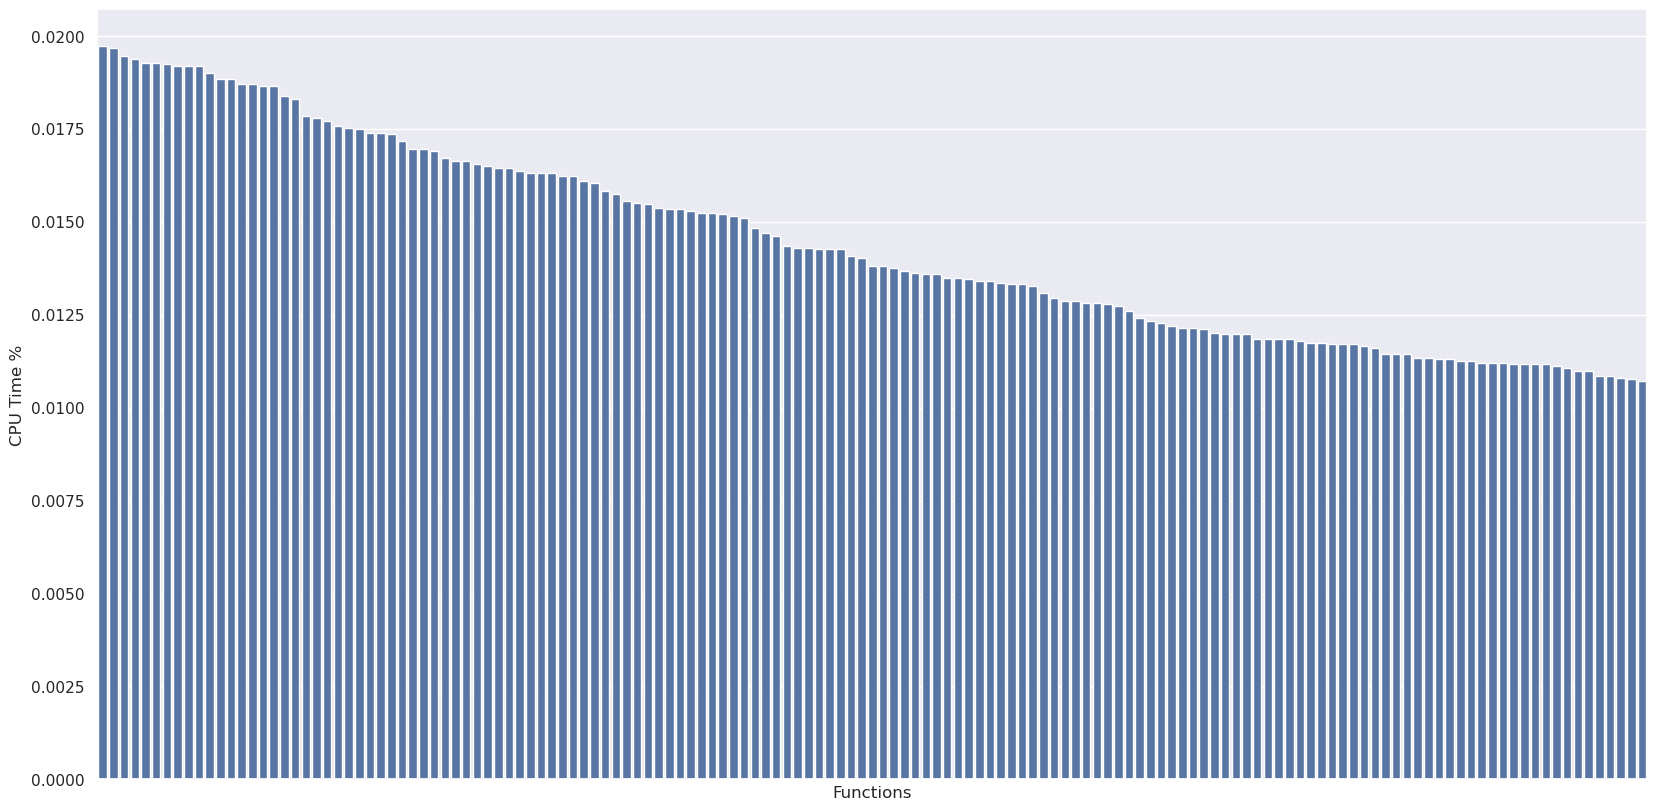

Total number of functions: 321
Total number of functions with CPU Time % < 0.02%: 106
% of functions with CPU Time % < 0.02%: 33.02%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.62%


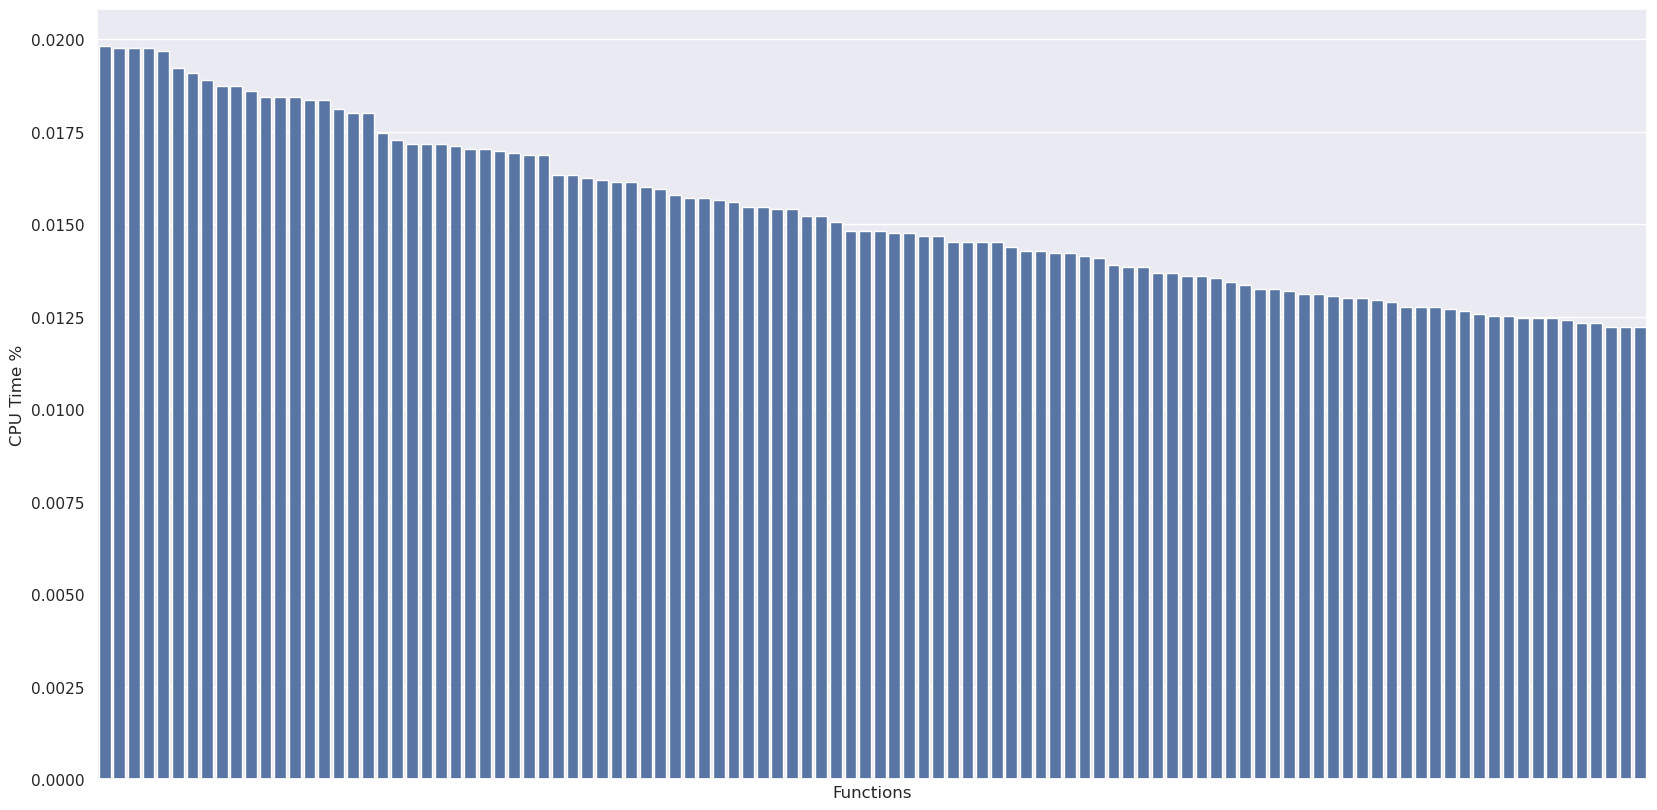

Total number of functions: 316
Total number of functions with CPU Time % < 0.02%: 105
% of functions with CPU Time % < 0.02%: 33.23%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.69%


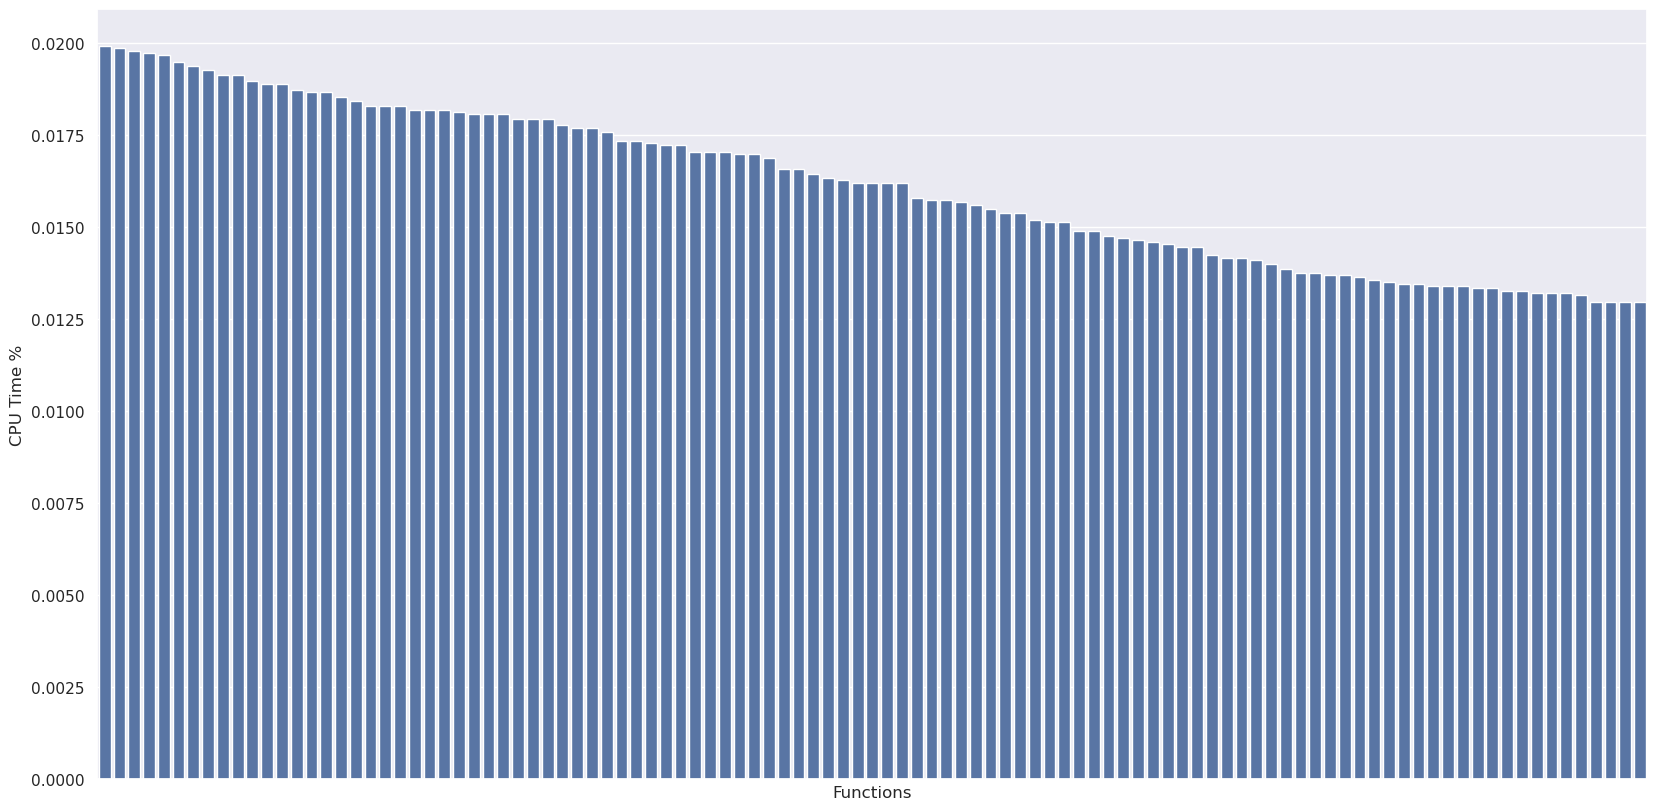

Total number of functions: 315
Total number of functions with CPU Time % < 0.02%: 88
% of functions with CPU Time % < 0.02%: 27.94%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.42%


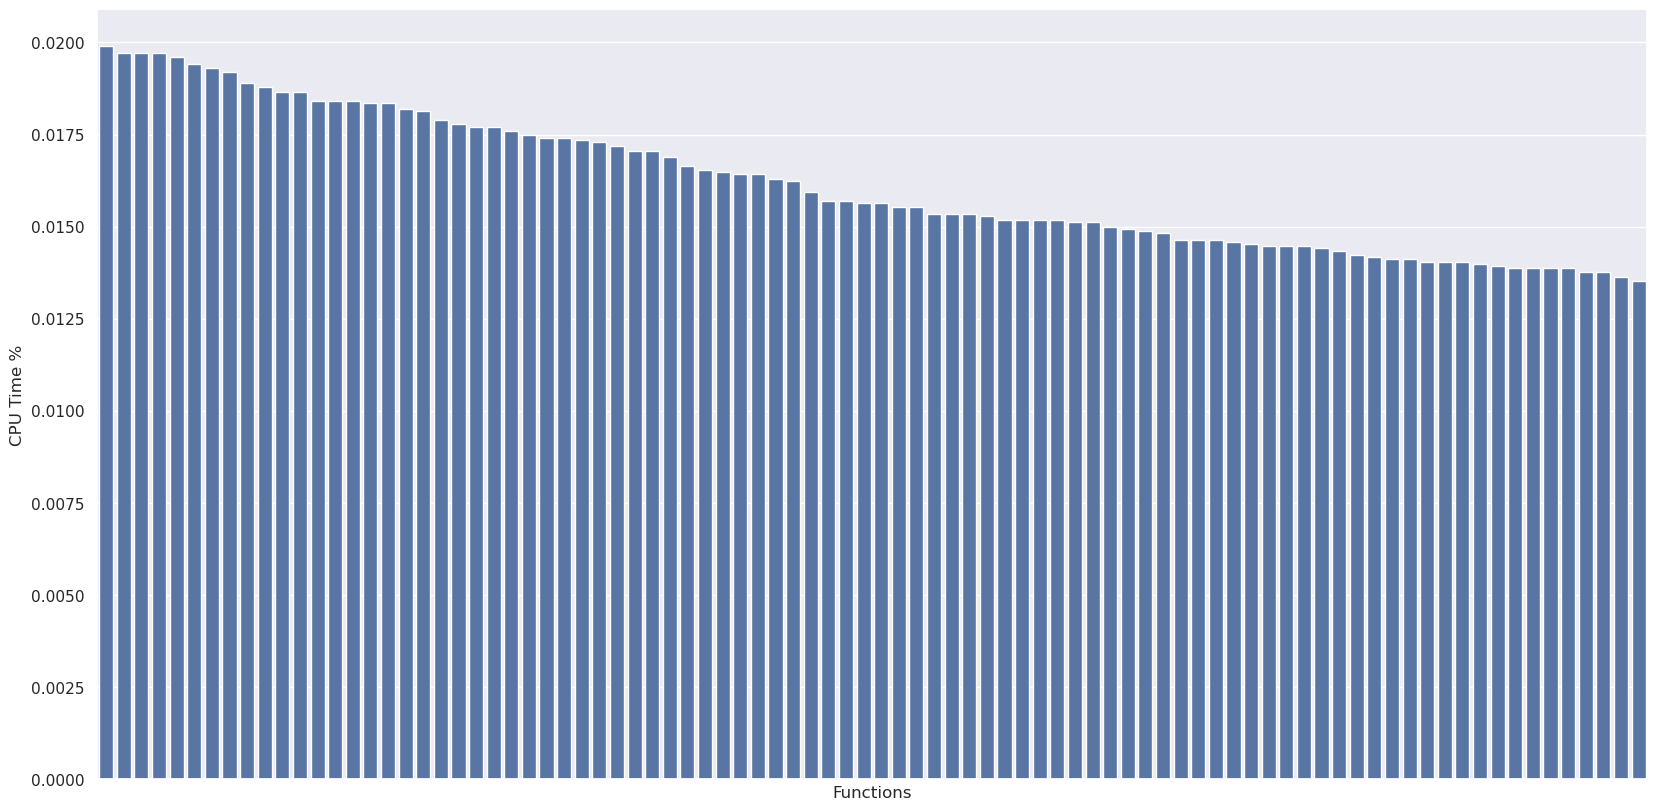

Total number of functions: 323
Total number of functions with CPU Time % < 0.02%: 125
% of functions with CPU Time % < 0.02%: 38.70%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.77%


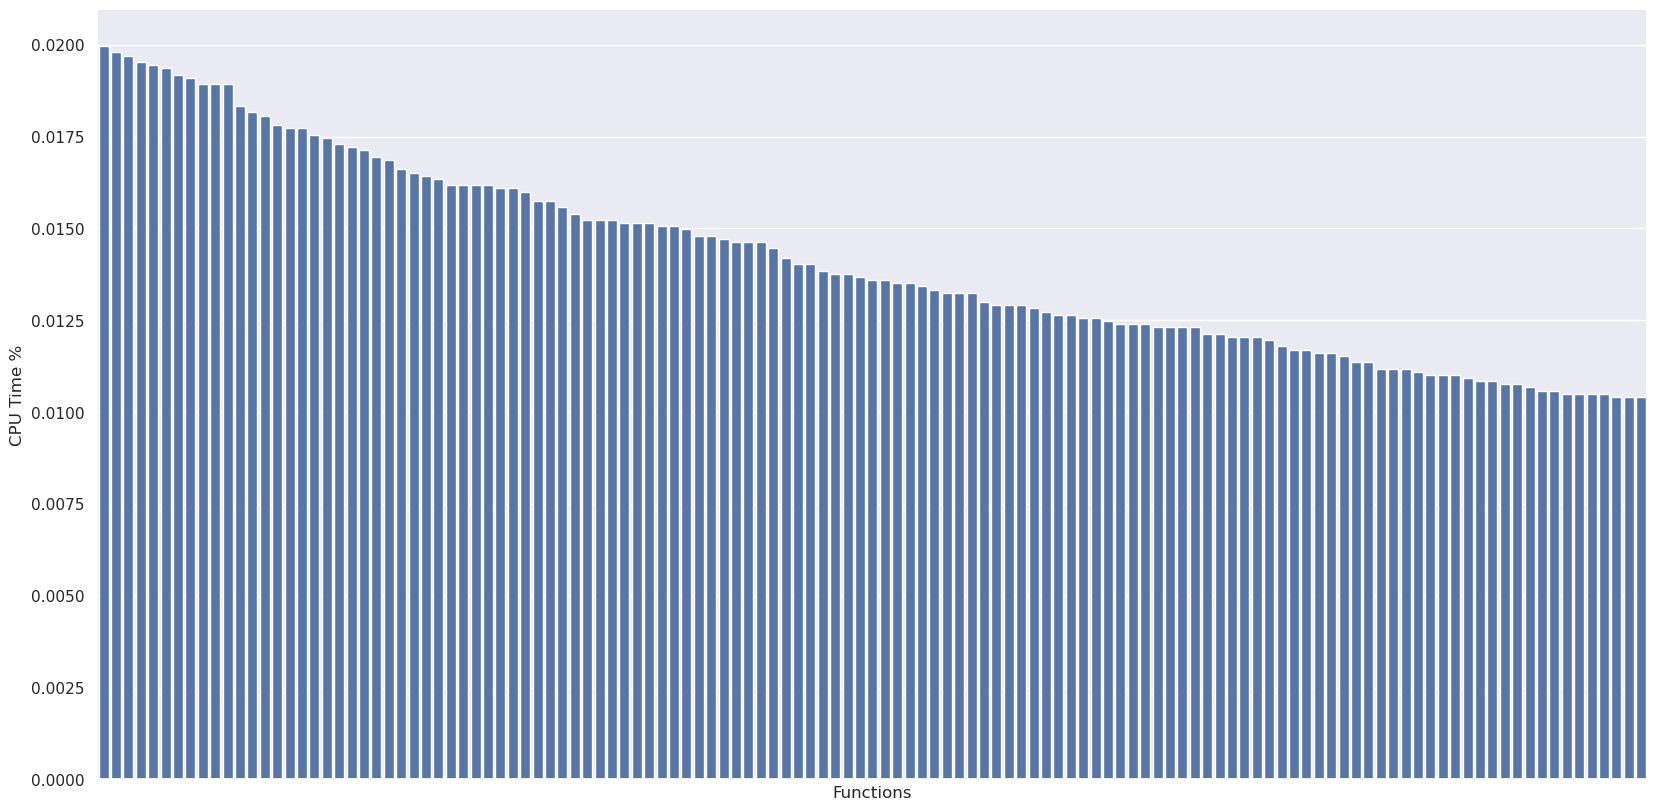

Total number of functions: 321
Total number of functions with CPU Time % < 0.02%: 122
% of functions with CPU Time % < 0.02%: 38.01%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.78%


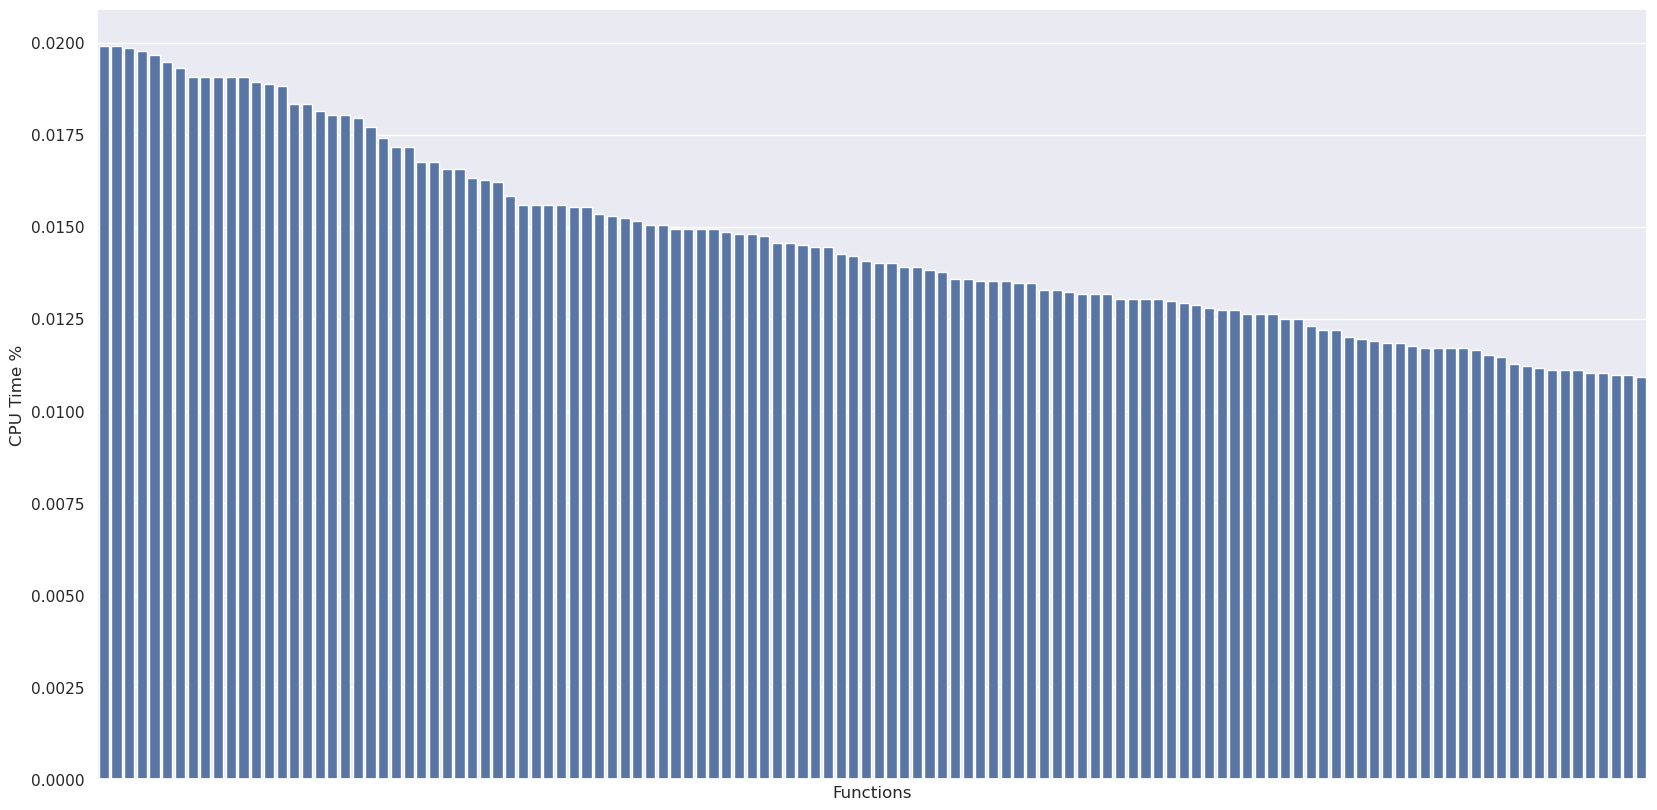

Total number of functions: 317
Total number of functions with CPU Time % < 0.02%: 119
% of functions with CPU Time % < 0.02%: 37.54%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.78%


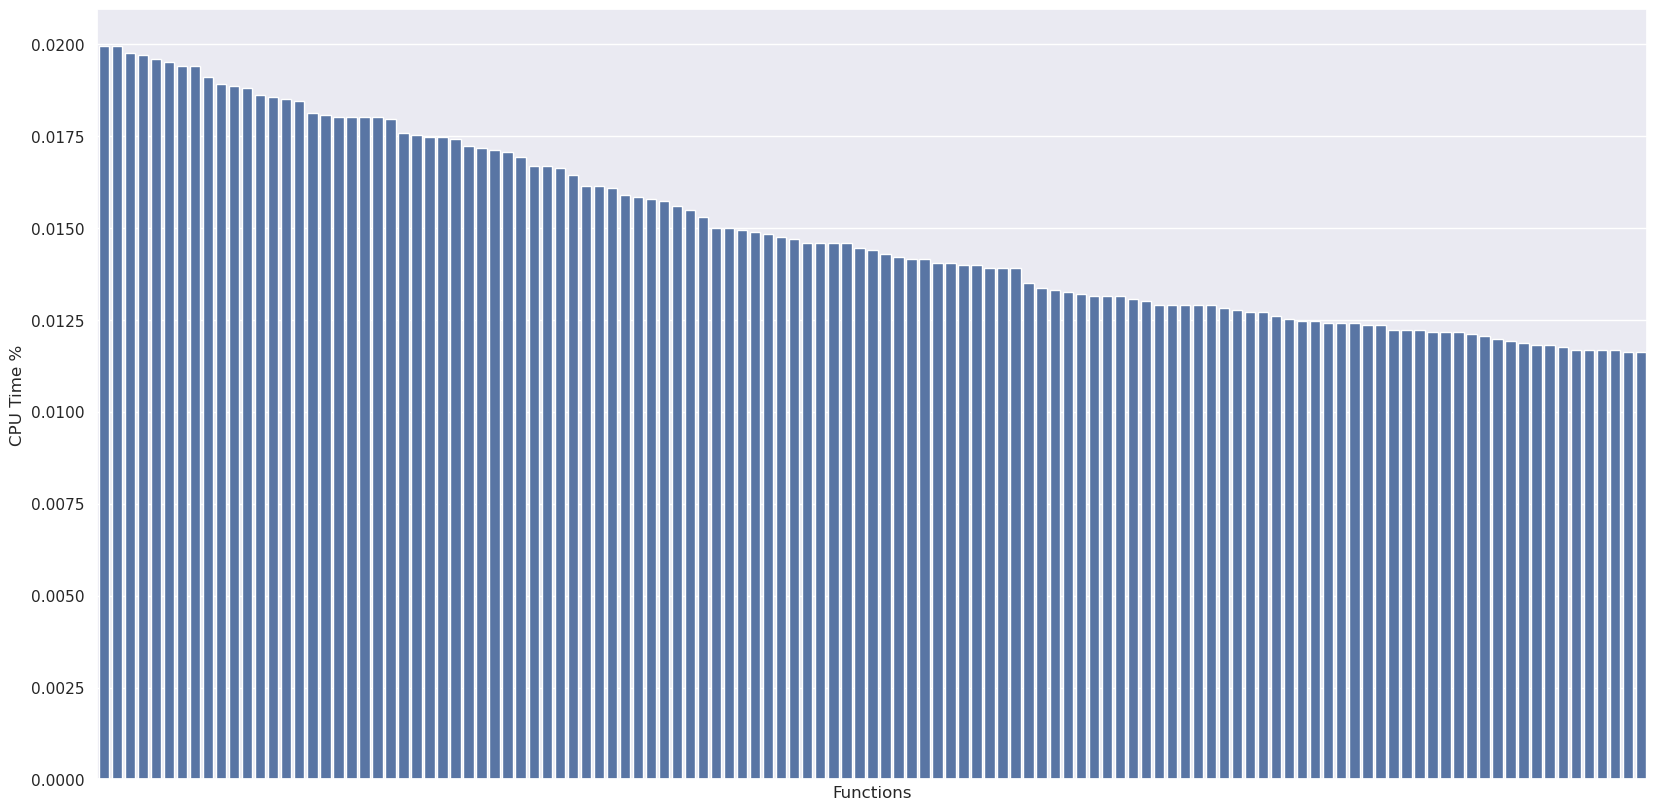

Total number of functions: 317
Total number of functions with CPU Time % < 0.02%: 113
% of functions with CPU Time % < 0.02%: 35.65%
Sum of CPU time for functions with CPU Time % < 0.02%: 1.78%


KeyboardInterrupt: 

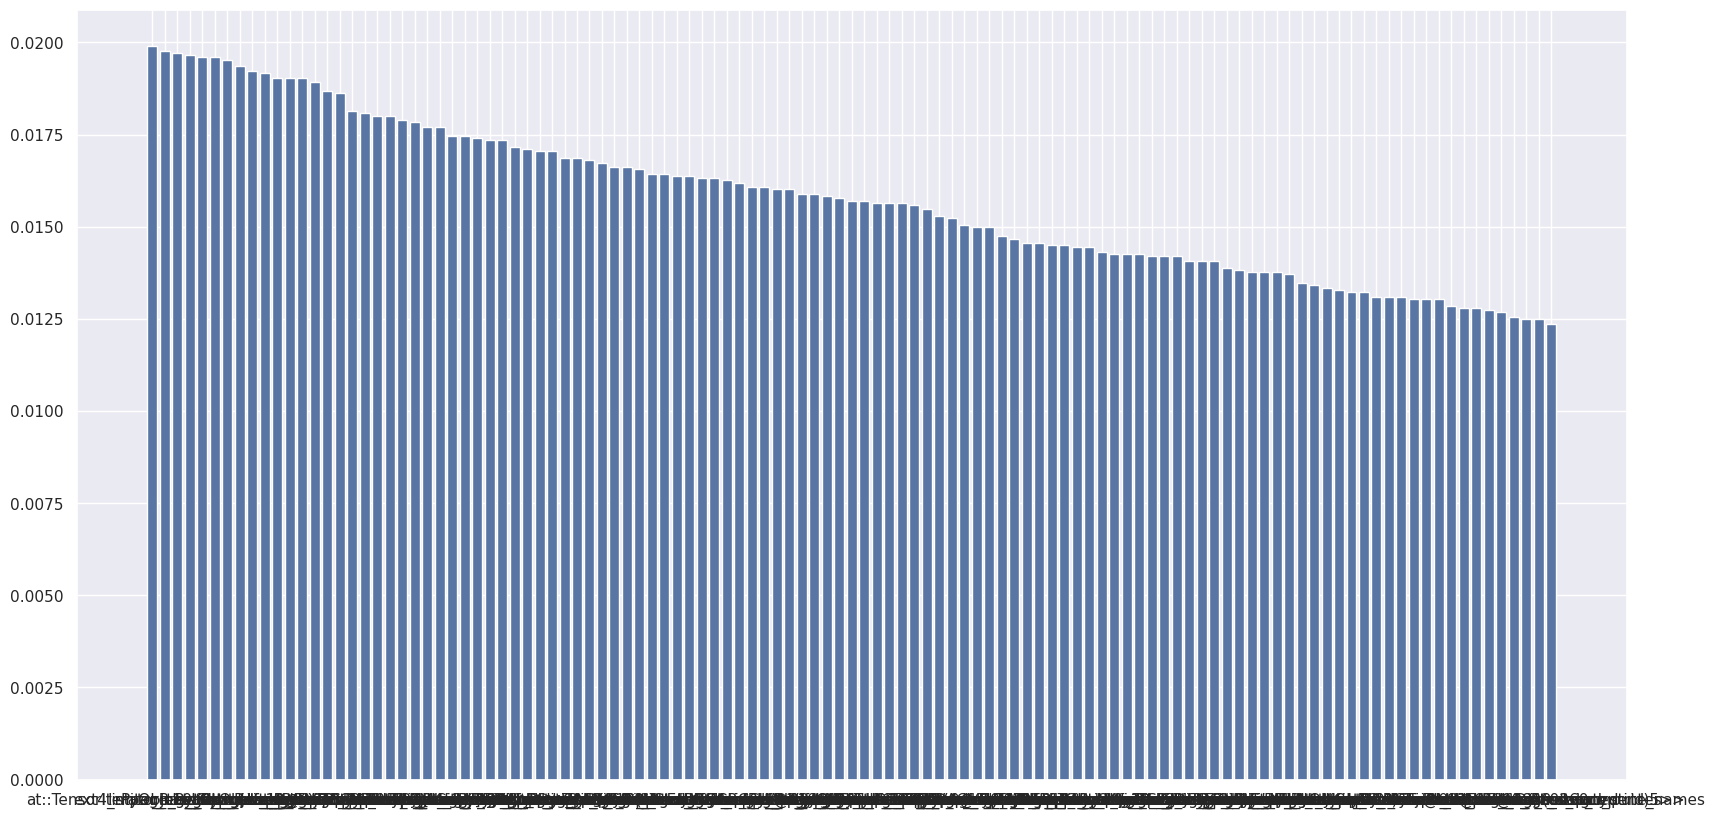

In [45]:
# %%
mapping_file = '/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/mapping_funcs.json'
uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_uarch_csvs'

# uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_vary_dataloaders_csv'


# %%
# load a json file
with open(mapping_file) as f:
    data = json.load(f)

cpp_funcs = set()

for py_func in data['op_to_func']:
    if py_func == 'RandomResizedCrop' or py_func == 'convertRGB':
        for cpp_func in data['op_to_func'][py_func]:
            cpp_funcs.add(cpp_func.split('|')[0])
interested_functions = list(cpp_funcs)

# previous interested_functions =

# ["__memmove_avx_unaligned_erms",\
# "_int_free",\
# "ImagingResampleHorizontal_8bpc",\
# "ImagingResampleVertical_8bpc",\
# "ImagingFlipLeftRight",\
# "ImagingPackRGB",\
# "munmap",\
# "copy_kernel",\
# "div_true_kernel",\
# "direct_copy_kernel",\
# "add_kernel",\
# "decompress_onepass",\
# "jpeg_idct_islow",\
# "jpeg_idct_16x16",\
# "ycc_rgb_convert",\
# "decode_mcu",\
# "ImagingUnpackRGB",\
# "__memset_avx2_unaligned_erms",\
# "__libc_calloc",\
#         ]
uarch_files = []
# loop through uarch_dir and find csv files
for file in os.listdir(uarch_dir):
    if not file.endswith(".csv"):
        print("Files other than csv exist ", uarch_dir)
        exit(1)
    uarch_files.append(file)

# natsort uarch_files
uarch_files = natsort.natsorted(uarch_files)
print(uarch_files)


def plot_cpu_time_distribution():
    # loop through uarch_dir and find csv files
    for uarch_file_ in uarch_files:
        if not file.endswith(".csv"):
            print("Files other than csv exist ", uarch_dir)
            exit(1)

        uarch_file = os.path.join(uarch_dir, uarch_file_)

        # %%
        #  read csv separated by tab
        df = pd.read_csv(uarch_file, sep='\t')

        # %%
        # remove trailing "s" in 'CPU Time' column and cast the column to float
        df['CPU Time'] = df['CPU Time'].str.rstrip('s').astype(float)
        # create a new column called "CPU Time %" from "CPU Time" column
        df['CPU Time %'] = df['CPU Time'] / df['CPU Time'].sum() * 100

        # remove all columns except 'CPU Time %' and 'Source Function / Function / Call Stack'
        df = df[['CPU Time %', 'Source Function / Function / Call Stack']]
        # %%
        # sort by 'CPU Time' column and reset index
        df = df.sort_values(by=['CPU Time %'], ascending=False).reset_index(drop=True)
                # rename 'CPU Time' column to 'CPU Time (s)'
        df = df.rename(columns={"CPU Time": "CPU Time (s)"})
        
        
        # rename 'Source Function / Function / Call Stack' column to 'Functions'
        df = df.rename(columns={"Source Function / Function / Call Stack": "Functions"})

        # drop duplicates
        df = df.drop_duplicates()

        # print total number of functions pretty printed
        total_funcs = len(df)
        print(f"Total number of functions: {len(df)}")

        drop_threshold = 0.02
        # remove functions with CPU Time < drop_threshold%
        df = df[df['CPU Time %'] < drop_threshold]
        # print total number of functions with CPU Time % < drop_threshold%
        print(f"Total number of functions with CPU Time % < {drop_threshold}%: {len(df)}")
        # print % of functions with CPU Time % < drop_threshold%
        print(f"% of functions with CPU Time % < {drop_threshold}%: {len(df)/total_funcs*100:.2f}%")
        # print sum of CPU time for functions with CPU Time % < drop_threshold% pretty printed
        print(f"Sum of CPU time for functions with CPU Time % < {drop_threshold}%: {df['CPU Time %'].sum():.2f}%") 

        # reset index
        df = df.reset_index(drop=True)

        # plot the distribution of 'CPU Time %' column
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Functions", y="CPU Time %", data=df)
        # make x axis labels empty
        plt.xticks([])
        # show plot
        plt.show()
    return

plot_cpu_time_distribution()